<a href="https://colab.research.google.com/github/fuyan2/ML_research/blob/master/simple_gan_classifier_as_discriminator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instructions for updating:
Colocations handled automatically by placer.


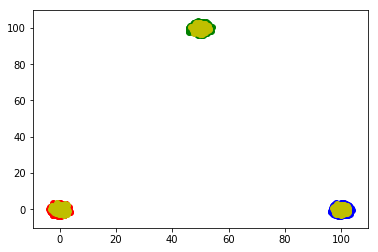

In [0]:
from __future__ import division, print_function, absolute_import

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random

tf.reset_default_graph()
tf.set_random_seed(1)

# Training Params
num_steps = 100000
learning_rate = 0.00001
x_dim = 2
noise_dim = 20
NUM_LABEL = 3
GAN_CLASS_COE = 500
gan_batch_size = GAN_CLASS_COE*NUM_LABEL
num_data = 10000
# A custom initialization (see Xavier Glorot init)
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.), dtype=tf.float32)
 
# Linear Regression 
class Generator(object):
  # G Parameters
  def __init__(self, noise_dim, NUM_LABEL, batch_size):
    self.batch_size = batch_size
    self.linear_w1 = tf.Variable(glorot_init([noise_dim+NUM_LABEL, 100]),name='glw1')
    self.linear_b1 = tf.Variable(glorot_init([100]),name='glb1')
    self.linear_w2 = tf.Variable(glorot_init([100, 50]),name='glw2')
    self.linear_b2 = tf.Variable(glorot_init([50]),name='glb2')
    self.linear_w3 = tf.Variable(glorot_init([50, x_dim]),name='glw3')
    self.linear_b3 = tf.Variable(glorot_init([x_dim]),name='glb3')
    
    self.training = True

 # Build G Graph
  def __call__(self, z,y):
    z_y = tf.concat((z,y),1)
    linear_z1 = tf.nn.leaky_relu(tf.matmul(z_y,self.linear_w1) + self.linear_b1)
    linear_z2 = tf.nn.leaky_relu(tf.matmul(linear_z1,self.linear_w2) + self.linear_b2)
    out_layer = tf.matmul(linear_z2,self.linear_w3)+self.linear_b3
    return out_layer

# Logistic Regression
class Disciminator(object):
  # D Parameters
  def __init__(self):
    self.linear_w1 = tf.Variable(glorot_init([x_dim + NUM_LABEL, 100]))
    self.linear_b1 = tf.Variable(glorot_init([100]))
    self.linear_w2 = tf.Variable(glorot_init([100, 1]))
    self.linear_b2 = tf.Variable(glorot_init([1]))

    self.training = True

  # Build D Graph
  def __call__(self, x, y):
    x_y = tf.concat((x,y),1)
    linear1 = tf.nn.leaky_relu(tf.matmul(x_y, self.linear_w1) + self.linear_b1)
    out = tf.matmul(linear1, self.linear_w2) + self.linear_b2
    out = tf.sigmoid(out)
    return out

class Classifier(object):
  def __init__(self):
    self.linear_w1 = tf.Variable(glorot_init([x_dim, NUM_LABEL]))
    self.linear_b1 = tf.Variable(glorot_init([NUM_LABEL]))
#     self.linear_w2 = tf.Variable(glorot_init([100, NUM_LABEL]))
#     self.linear_b2 = tf.Variable(glorot_init([NUM_LABEL]))

    self.training = True

  # Build D Graph
  def __call__(self, x):
    out = tf.matmul(x, self.linear_w1) + self.linear_b1
#     out = tf.matmul(linear1, self.linear_w2) + self.linear_b2
    out = tf.nn.softmax(out)
    return out
  
  
def plot_gan_image(name, epoch, sess):
  # Generate images from noise, using the generator network.
  fig, ax = plt.subplots()
  for i in range(NUM_LABEL):   
    # Desired label
    d_label = np.zeros([gan_batch_size, NUM_LABEL])
    d_label[:] = i
    # Noise input.
    z = np.random.uniform(-1., 1., size=[gan_batch_size, noise_dim])
    g = sess.run([gen_sample], feed_dict={gen_input: z, desired_label: d_label})
    g = np.reshape(g, [gan_batch_size,2])
    if i == 0:
      ax.scatter(g[:,0], g[:,1], c='r')
    elif i == 1:
      ax.scatter(g[:,0], g[:,1], c='b')
    elif i == 2:
      ax.scatter(g[:,0], g[:,1], c='g')
     
  # f.show()
  plt.savefig(name+epoch)

# Build Dataset
features = tf.placeholder(tf.float32, shape=[None, x_dim])
labels = tf.placeholder(tf.float32, shape=[None, NUM_LABEL])
batch_size = tf.placeholder(tf.int64)
sample_size = tf.placeholder(tf.int64)
dataset = tf.data.Dataset.from_tensor_slices((features, labels))
dataset = dataset.shuffle(sample_size, reshuffle_each_iteration=True)
dataset = dataset.batch(batch_size, drop_remainder=True).repeat()
iter = dataset.make_initializable_iterator()
next_batch = iter.get_next()

mu1 = [0., 0.]
sigma1 = [[1., 0.], [0., 1.]]
mu2 = [100., 0.]
sigma2 = [[1., 0.], [0., 1.]]
mu3 = [50., 100.]
x_1 = np.random.multivariate_normal(mu1, sigma1, num_data)
x_2 = np.random.multivariate_normal(mu2, sigma1, num_data)
x_3 = np.random.multivariate_normal(mu3, sigma1, num_data)

plt.scatter(x_1[:,0], x_1[:,1], c='r')
plt.scatter(x_2[:,0], x_2[:,1], c='b')
plt.scatter(x_3[:,0], x_3[:,1], c='g')

x_train = np.concatenate((x_1, x_2, x_3), axis=0)
y_train = np.zeros([num_data*NUM_LABEL, NUM_LABEL])
for i in range(NUM_LABEL):
  y_train[i*num_data:(i+1)*num_data, i] = 1.
  
#aux_data is same as data1
aux_mu1 = [0., 0.]
aux_mu2 = [50., 0.]
aux_mu3 = [0., 0.]

aux_data1 = np.random.multivariate_normal(mu1, sigma1, 500)
aux_data2 = np.random.multivariate_normal(mu2, sigma1, 500)
aux_data3 = np.random.multivariate_normal(mu3, sigma1, 500)

aux_data = np.concatenate((aux_data1, aux_data2, aux_data3), axis=0)
# random.shuffle(aux_data)
plt.scatter(aux_data[:,0], aux_data[:,1], c='y')


# Build The Classifier
x = tf.placeholder(tf.float32, shape=[None, x_dim])
y = tf.placeholder(tf.float32, shape=[None, NUM_LABEL])
model = Classifier()
y_ml = model(x)
model_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=y_ml))

y_pred = tf.argmax(y_ml, 1)
correct = tf.equal(tf.argmax(y_ml, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

model_optimizer = tf.train.AdamOptimizer(0.001).minimize(model_loss, var_list=[model.linear_w1, model.linear_b1])

# Build Networks
# Network Inputs
gen_input = tf.placeholder(tf.float32, shape=[None, noise_dim], name='input_noise')
# aux_x = tf.placeholder(tf.float32, shape=[None, x_dim])
# aux_label = model(aux_x)
# desired_label = tf.one_hot(tf.argmax(aux_label, 1), NUM_LABEL) 

###### USE MODEL AS DISCRIMINATOR #######
desired_label = tf.placeholder(tf.float32, shape=[None, NUM_LABEL])
########

# Build G Network
G = Generator(noise_dim, NUM_LABEL, gan_batch_size)
gen_sample = G(gen_input,desired_label)
gen_label =  model(gen_sample)

# # Build 2 D Networks (one from noise input, one from generated samples)
# D = Disciminator()
# disc_real = D(aux_x, aux_label)
# disc_fake = D(gen_sample, gen_label)

# # Build Loss
gan_class_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=desired_label, logits=gen_label))

# gen_loss = -tf.reduce_mean(tf.log(tf.maximum(0.1, disc_fake))) + GAN_CLASS_COE*gan_class_loss
# disc_loss = -tf.reduce_mean(tf.log(tf.maximum(0.1, disc_real)) + tf.log(tf.maximum(0.1, 1. - disc_fake)))

# # gen_loss = -tf.reduce_mean(disc_fake) + GAN_CLASS_COE*gan_class_loss
# # disc_loss = -tf.reduce_mean(disc_real) + tf.reduce_mean(disc_fake) 

# # Build Optimizers
optimizer_gen = tf.train.AdamOptimizer(learning_rate=learning_rate)
# optimizer_disc = tf.train.AdamOptimizer(learning_rate=learning_rate)

# # G Network Variables
gen_vars = [G.linear_w1, G.linear_b1, G.linear_w2, G.linear_b2, G.linear_w3, G.linear_b3]
# # D Network Variables
# disc_vars = [D.linear_w1, D.linear_b1, D.linear_w2, D.linear_b2]

# # Create training operations
# train_gen = optimizer_gen.minimize(gen_loss, var_list=gen_vars)
train_gen = optimizer_gen.minimize(gan_class_loss, var_list=gen_vars)
# train_disc = optimizer_disc.minimize(disc_loss, var_list=disc_vars)

Epoch 0, training accuracy 0.426667
Epoch 500, training accuracy 0.516667
Epoch 1000, training accuracy 0.659333
Epoch 1500, training accuracy 1
Epoch 2000, training accuracy 1
Epoch 2500, training accuracy 1
test acc: 1.0
cluster1:  (10000, 2) cluster2:  (10000, 2) cluster3: (10000, 2)
Epoch 0: Generator Loss: 1.204477
Epoch 2000: Generator Loss: 1.194506
Epoch 4000: Generator Loss: 1.149552
Epoch 6000: Generator Loss: 1.042978
Epoch 8000: Generator Loss: 0.962108
Epoch 10000: Generator Loss: 0.919036
Epoch 12000: Generator Loss: 0.891321
Epoch 14000: Generator Loss: 0.875196
Epoch 16000: Generator Loss: 0.865619
Epoch 18000: Generator Loss: 0.860672
Epoch 20000: Generator Loss: 0.858126
Epoch 22000: Generator Loss: 0.856491
Epoch 24000: Generator Loss: 0.855512
Epoch 26000: Generator Loss: 0.854935
Epoch 28000: Generator Loss: 0.854619
Epoch 30000: Generator Loss: 0.854369
Epoch 32000: Generator Loss: 0.854199
Epoch 34000: Generator Loss: 0.854097
Epoch 36000: Generator Loss: 0.85404

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Epoch 40000: Generator Loss: 0.853923
Epoch 42000: Generator Loss: 0.853880
Epoch 44000: Generator Loss: 0.853827
Epoch 46000: Generator Loss: 0.853730
Epoch 48000: Generator Loss: 0.853007
Epoch 50000: Generator Loss: 0.843626
Epoch 52000: Generator Loss: 0.760528
Epoch 54000: Generator Loss: 0.640011
Epoch 56000: Generator Loss: 0.581183
Epoch 58000: Generator Loss: 0.563553
Epoch 60000: Generator Loss: 0.556669
Epoch 62000: Generator Loss: 0.553662
Epoch 64000: Generator Loss: 0.552397
Epoch 66000: Generator Loss: 0.551838
Epoch 68000: Generator Loss: 0.551605
Epoch 70000: Generator Loss: 0.551509
Epoch 72000: Generator Loss: 0.551471
Epoch 74000: Generator Loss: 0.551455
Epoch 76000: Generator Loss: 0.551449
Epoch 78000: Generator Loss: 0.551446
Epoch 80000: Generator Loss: 0.551445
Epoch 82000: Generator Loss: 0.551445
Epoch 84000: Generator Loss: 0.551445
Epoch 86000: Generator Loss: 0.551445
Epoch 88000: Generator Loss: 0.551445
Epoch 90000: Generator Loss: 0.551445
Epoch 92000:

KeyboardInterrupt: ignored

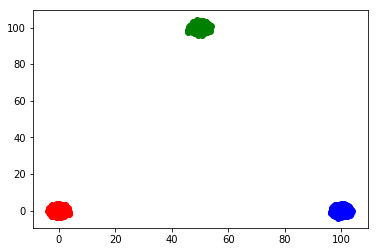

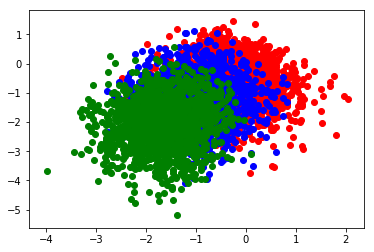

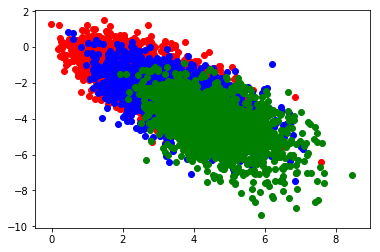

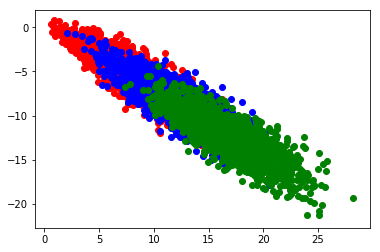

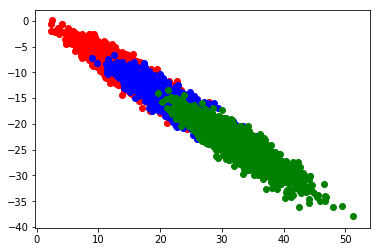

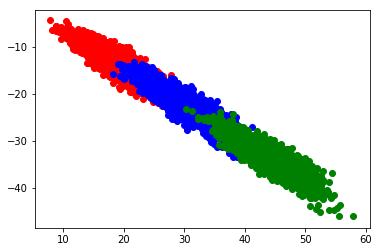

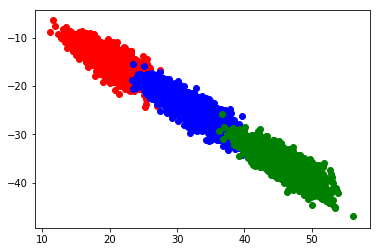

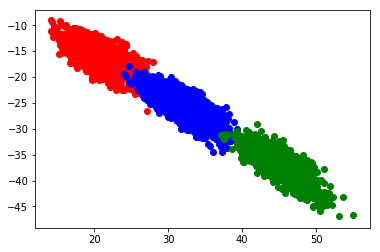

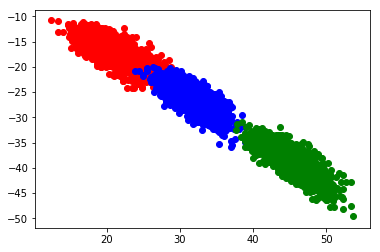

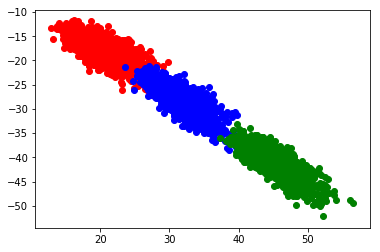

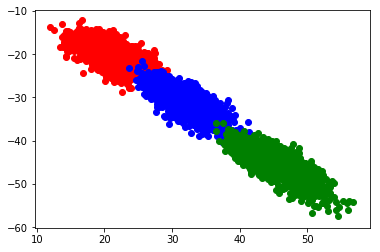

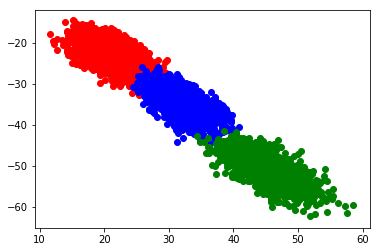

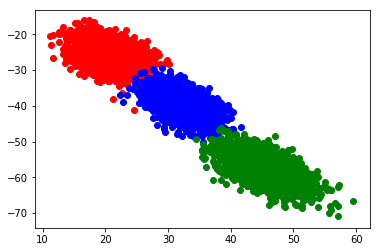

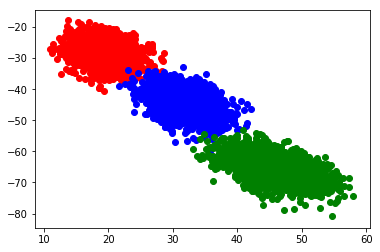

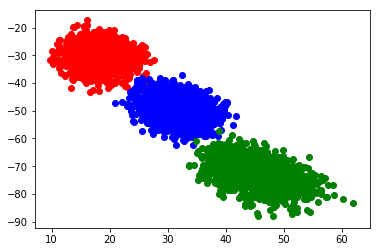

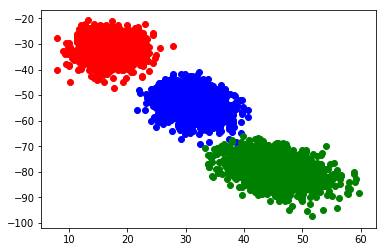

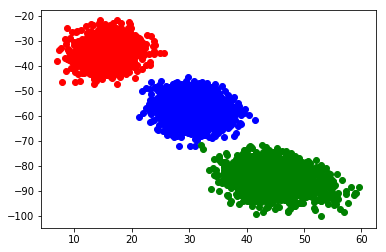

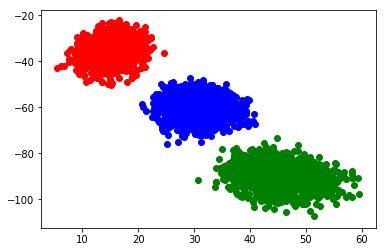

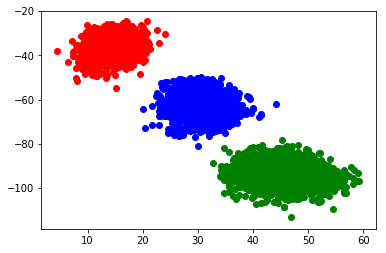

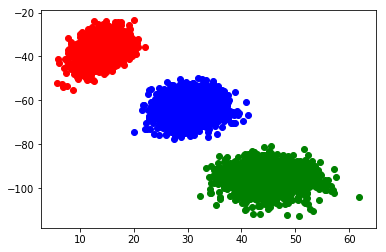

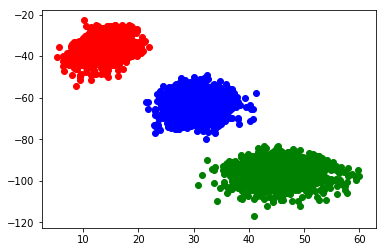

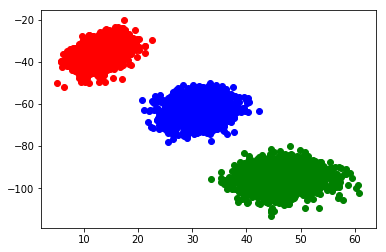

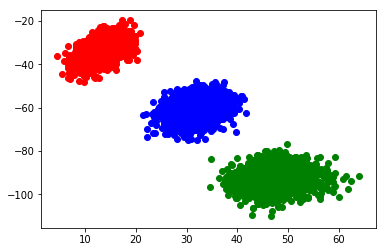

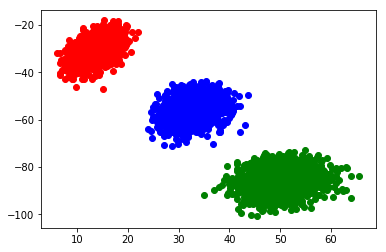

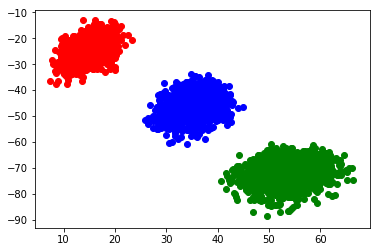

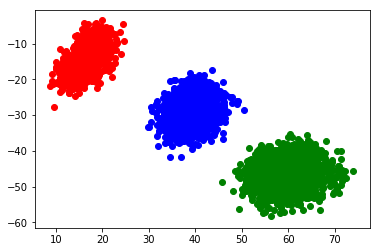

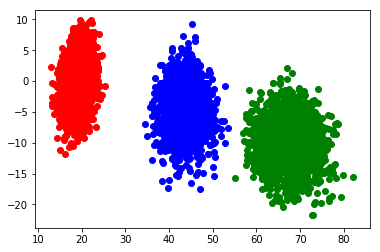

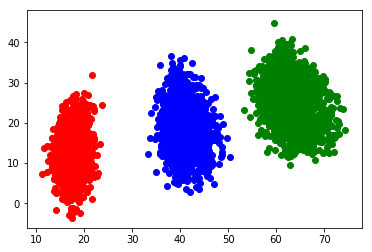

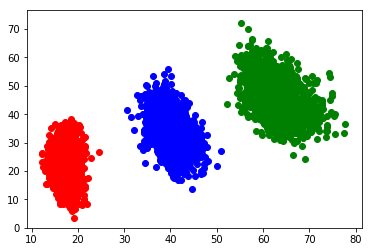

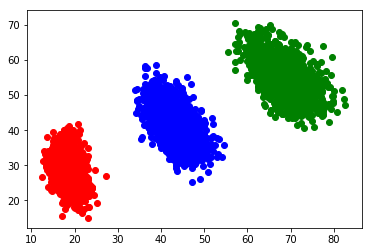

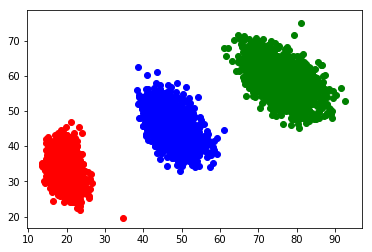

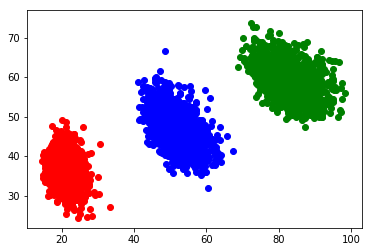

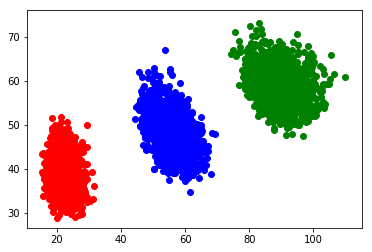

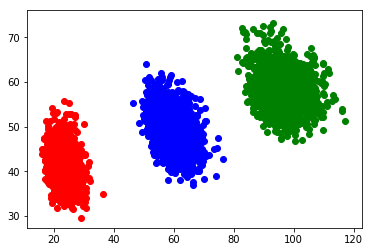

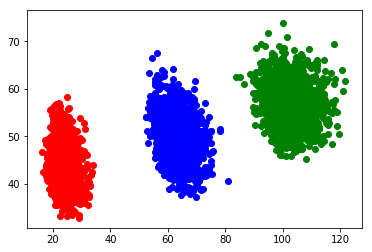

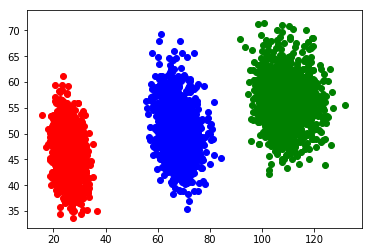

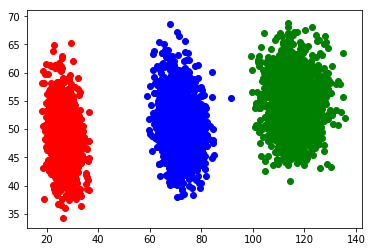

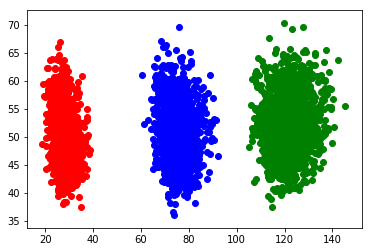

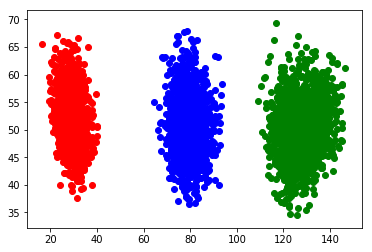

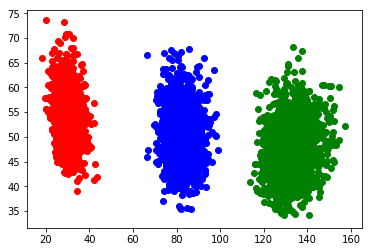

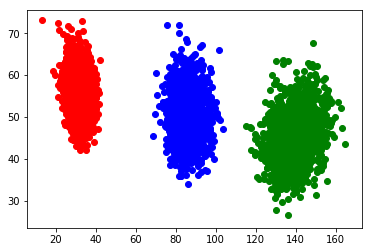

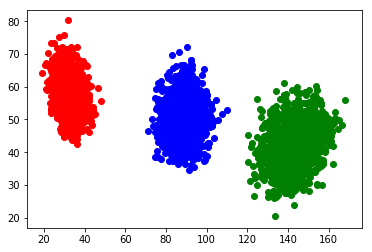

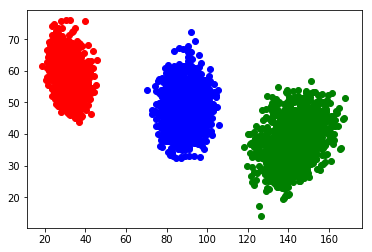

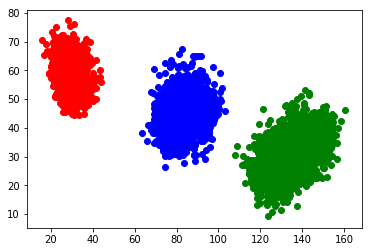

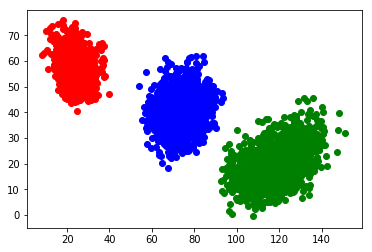

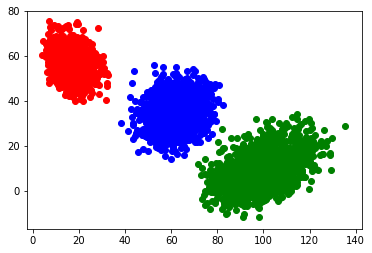

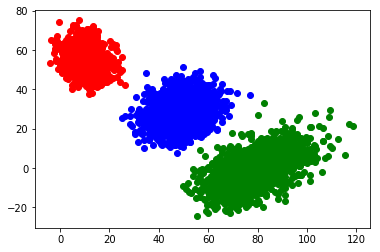

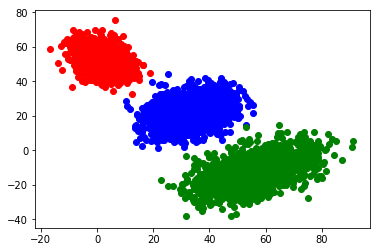

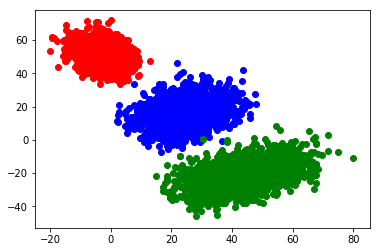

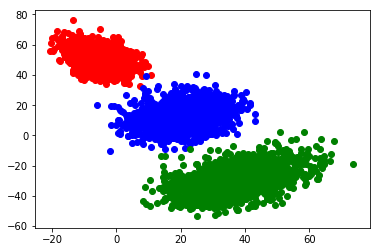

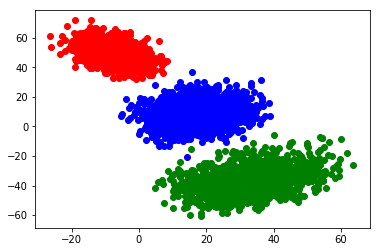

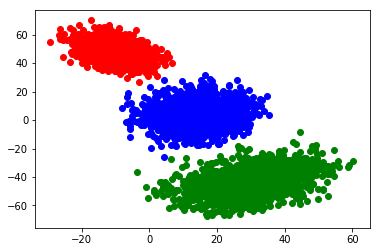

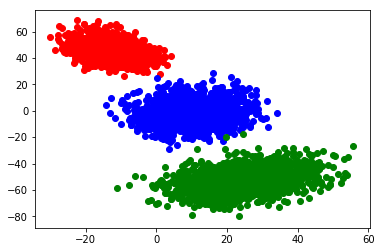

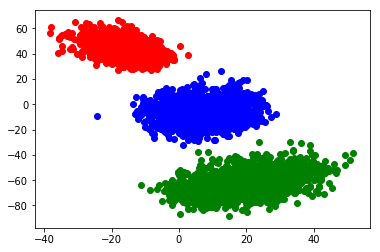

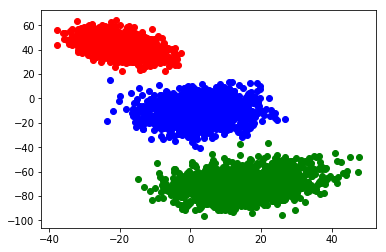

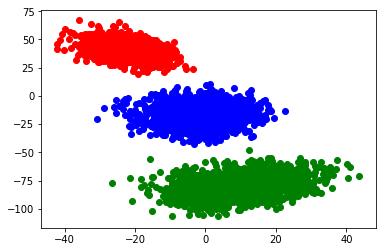

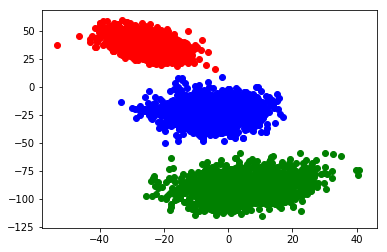

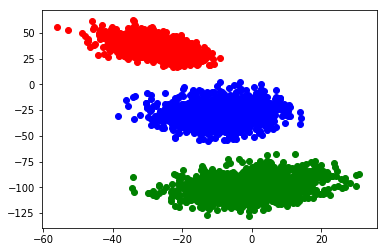

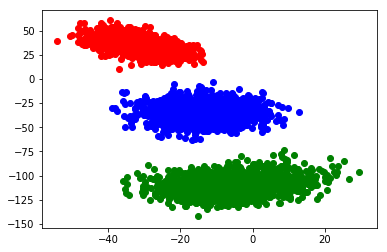

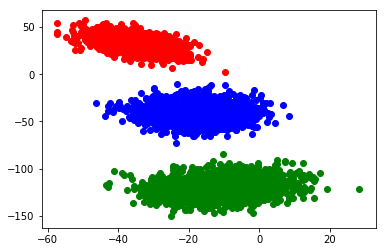

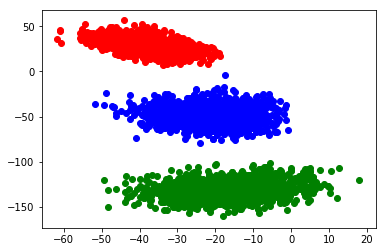

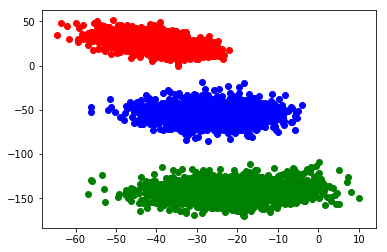

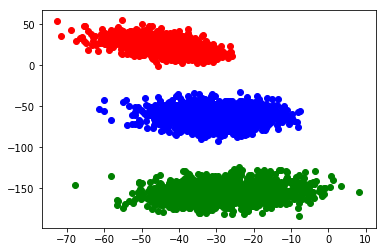

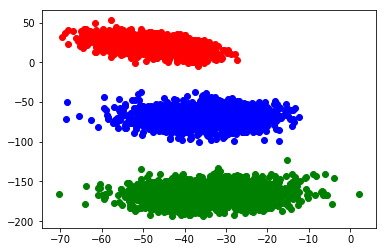

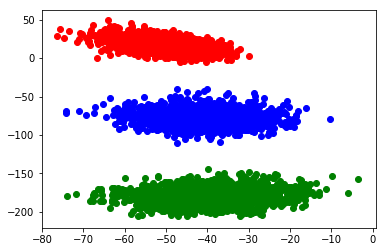

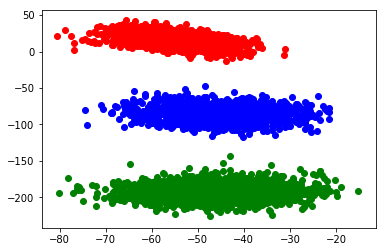

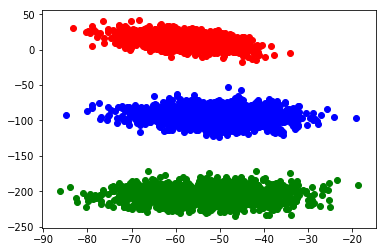

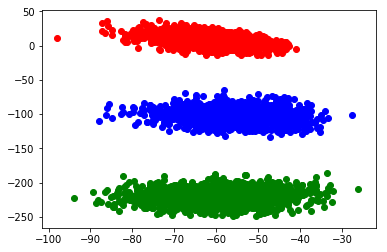

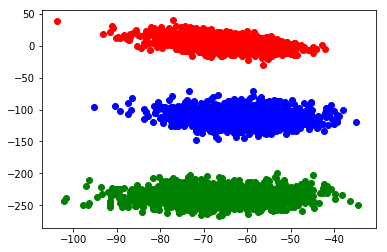

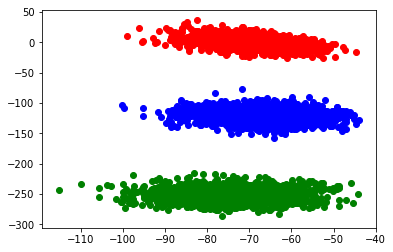

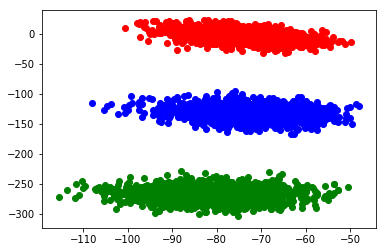

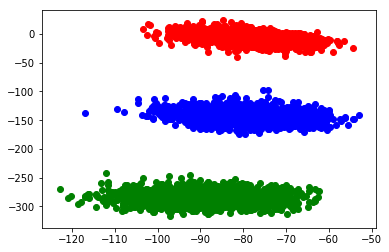

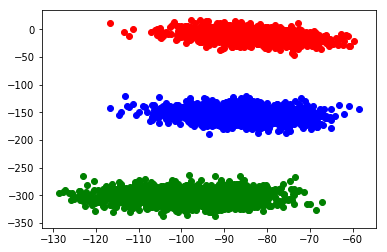

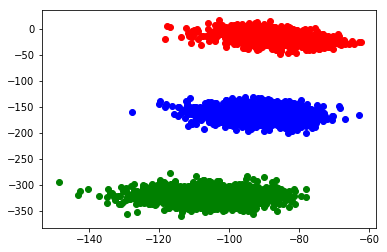

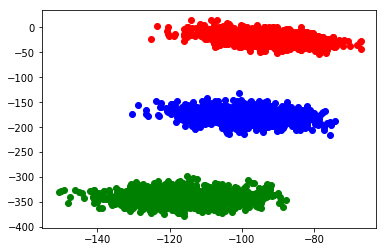

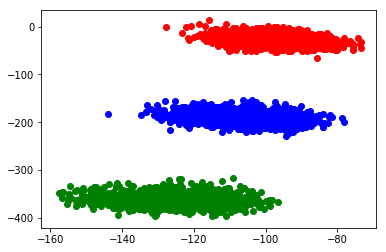

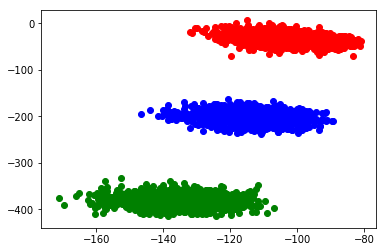

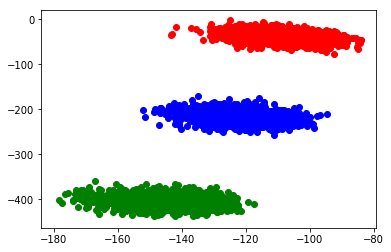

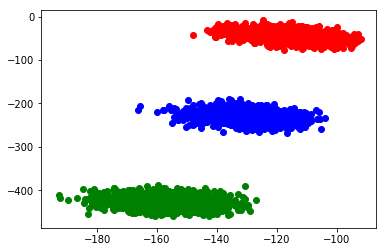

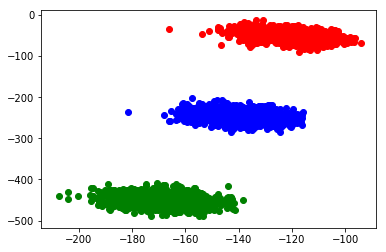

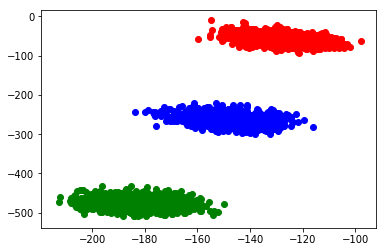

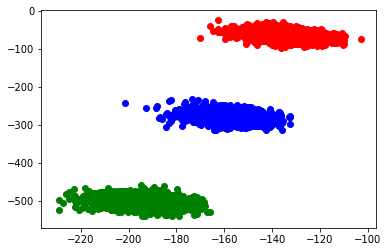

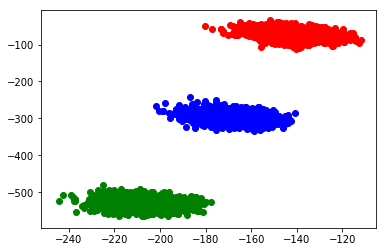

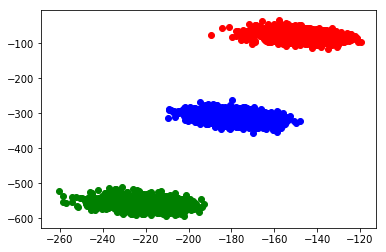

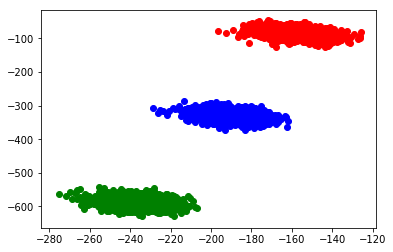

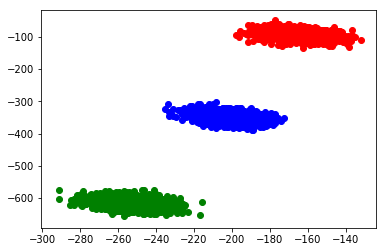

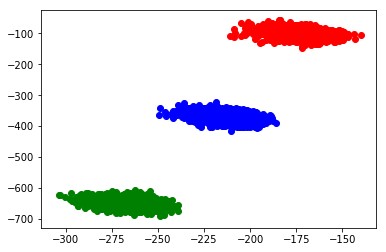

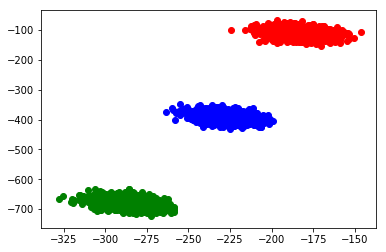

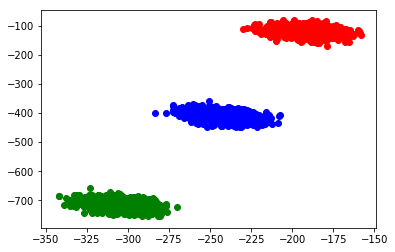

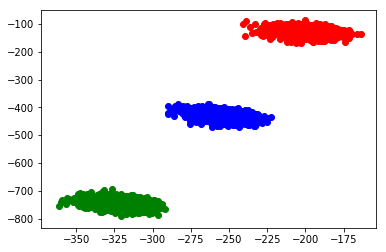

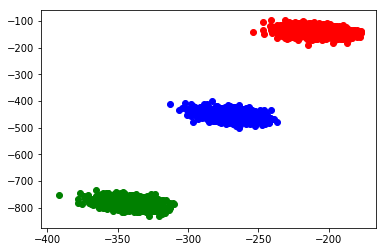

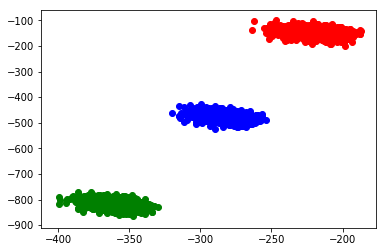

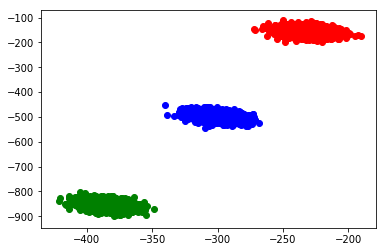

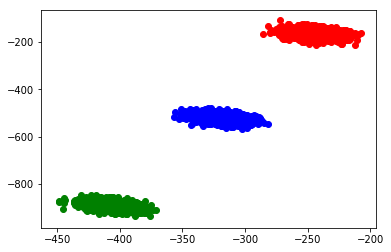

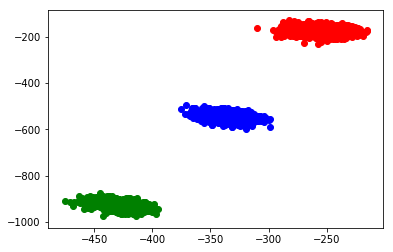

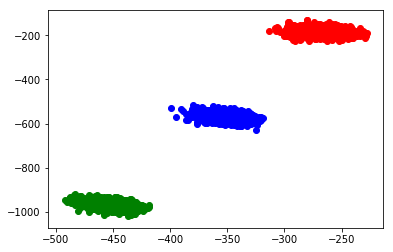

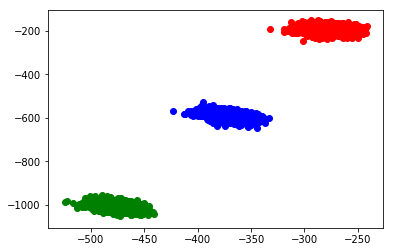

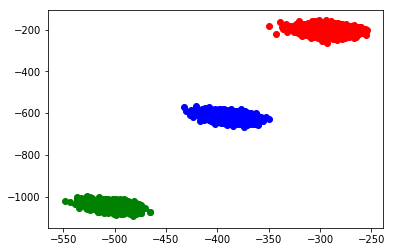

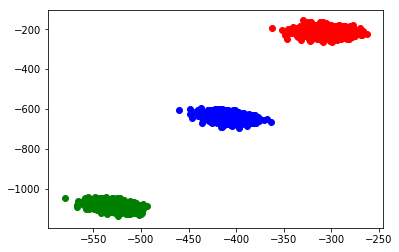

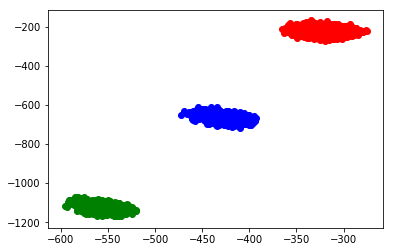

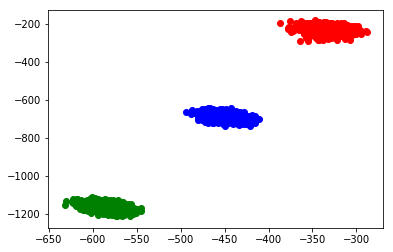

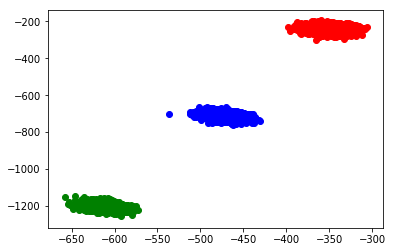

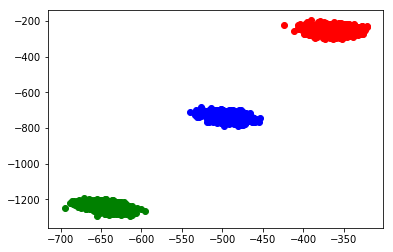

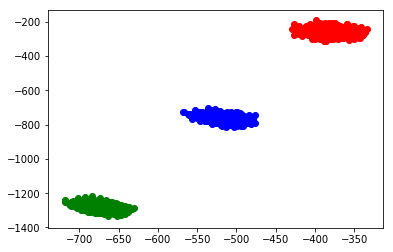

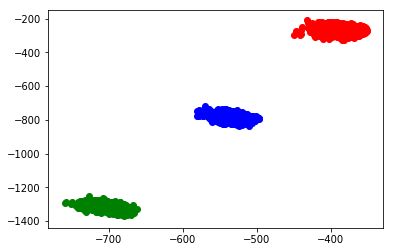

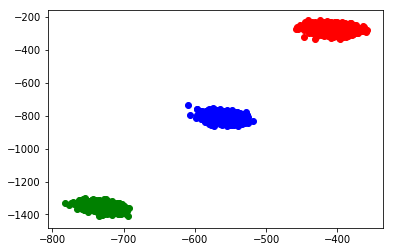

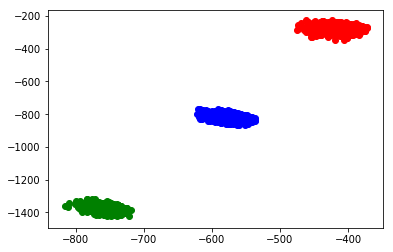

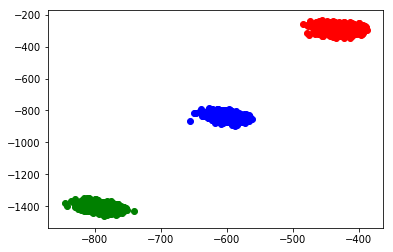

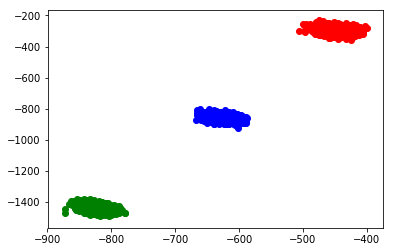

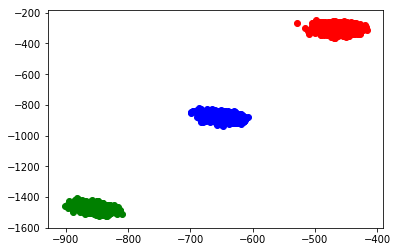

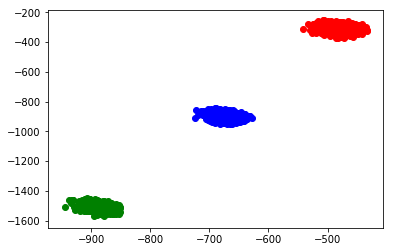

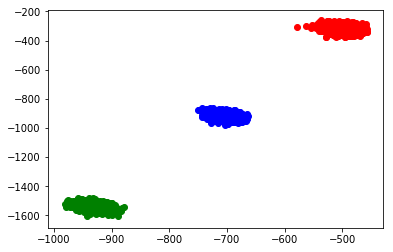

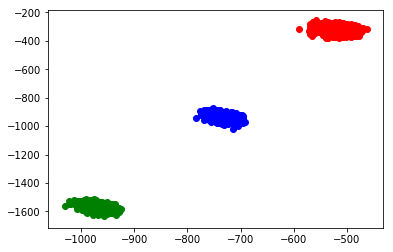

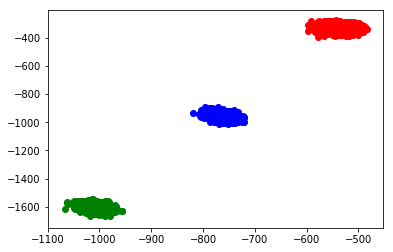

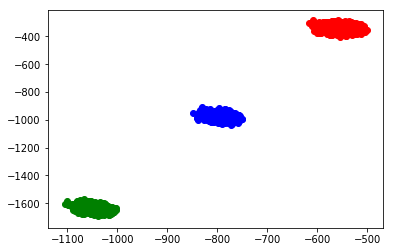

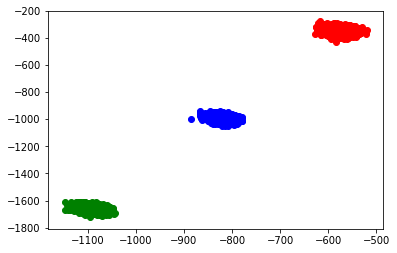

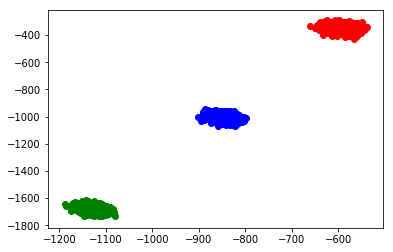

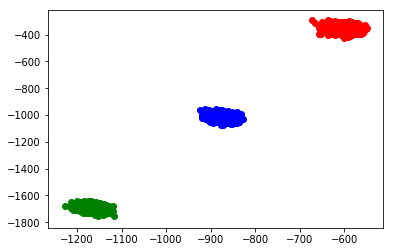

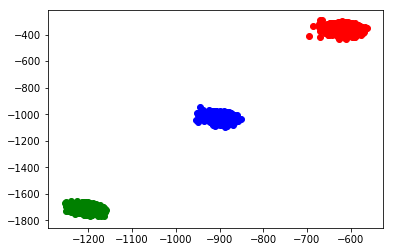

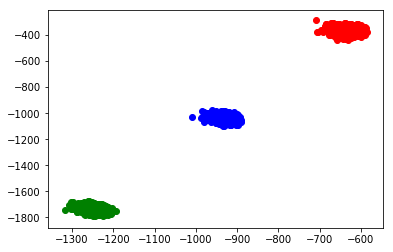

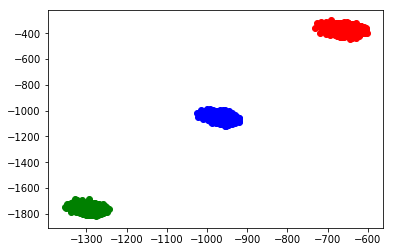

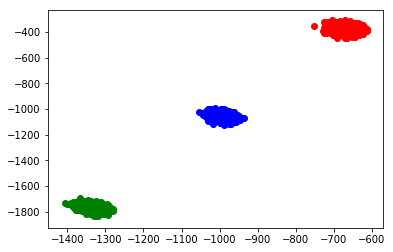

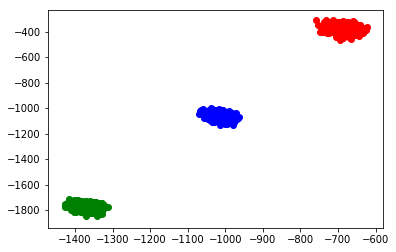

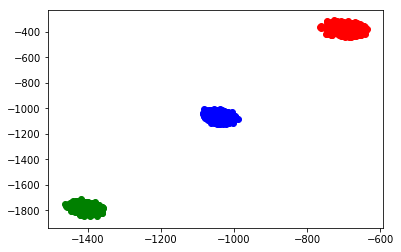

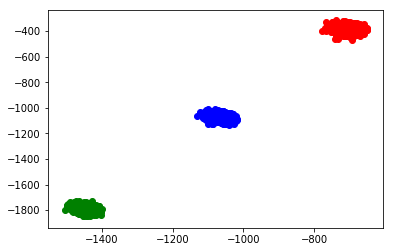

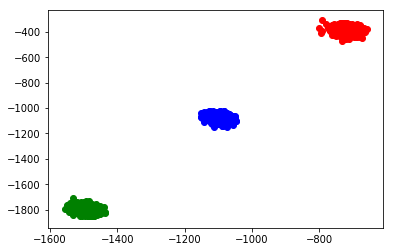

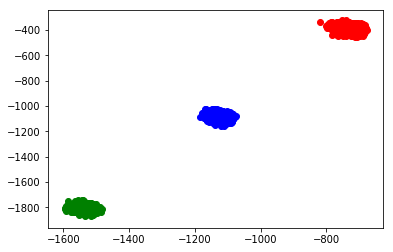

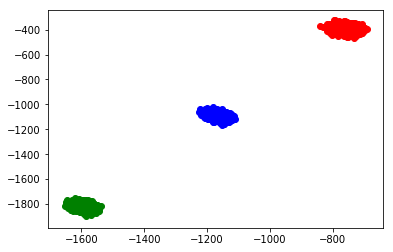

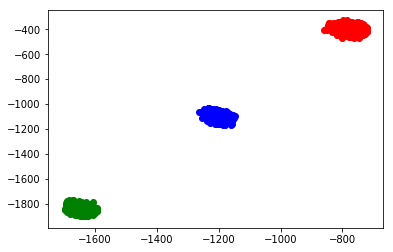

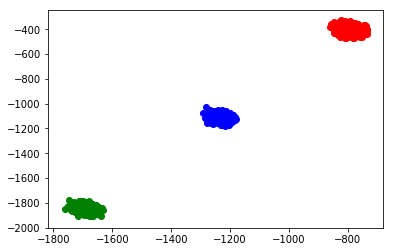

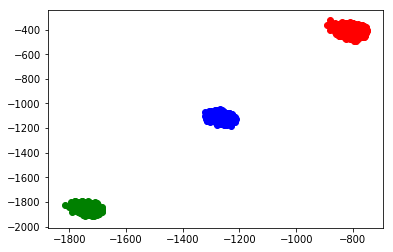

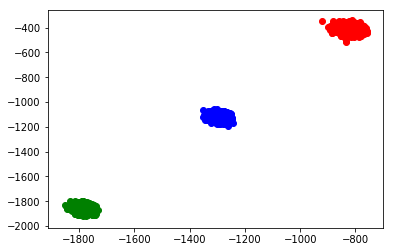

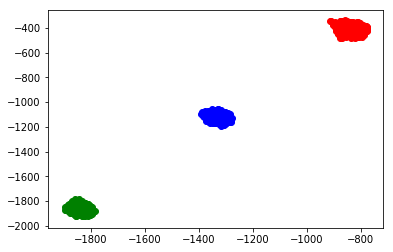

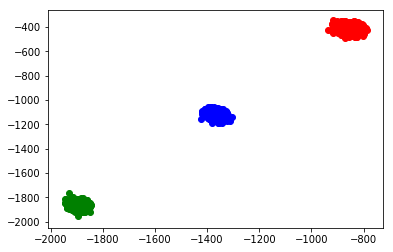

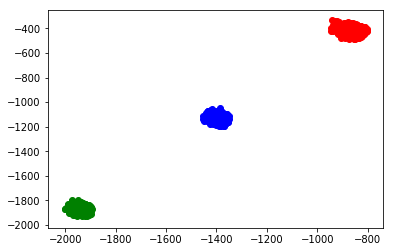

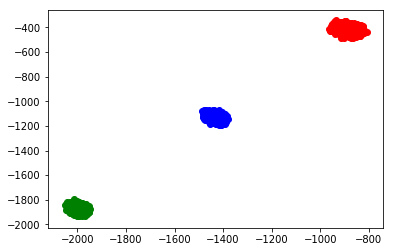

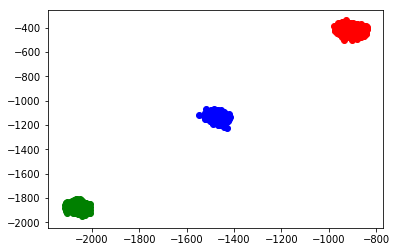

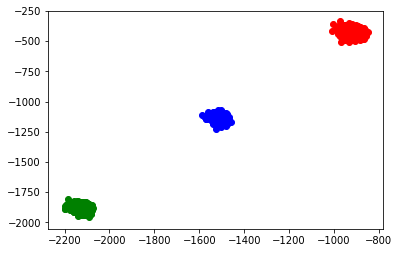

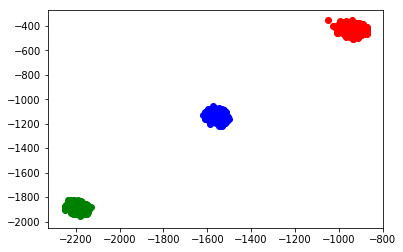

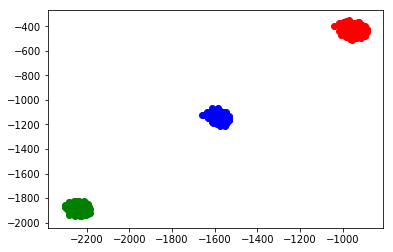

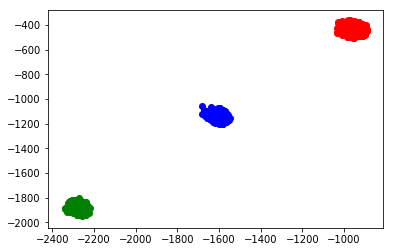

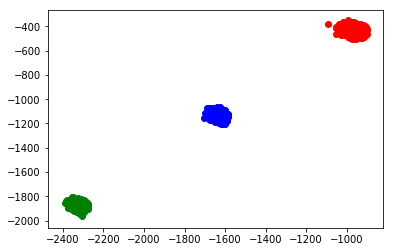

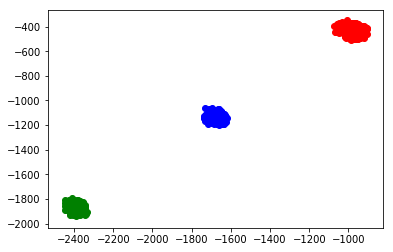

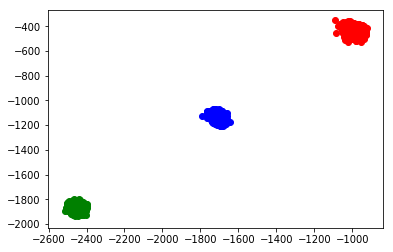

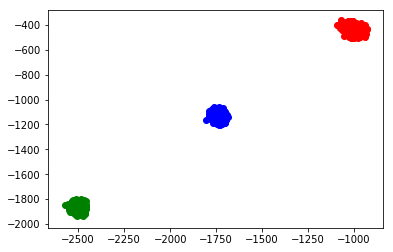

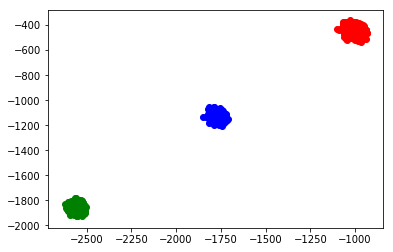

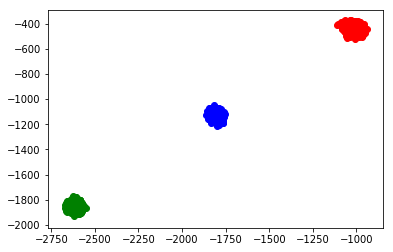

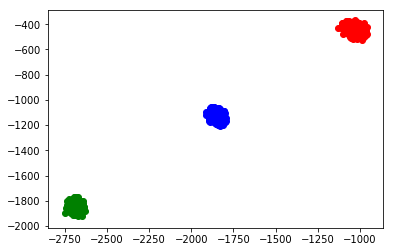

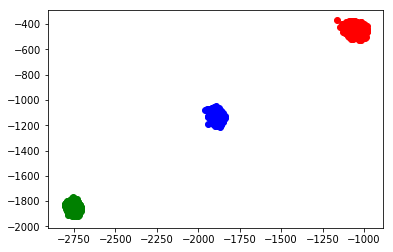

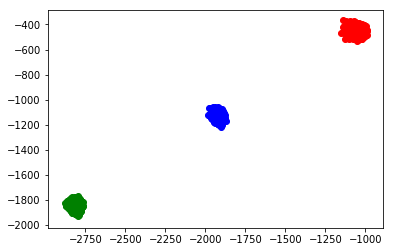

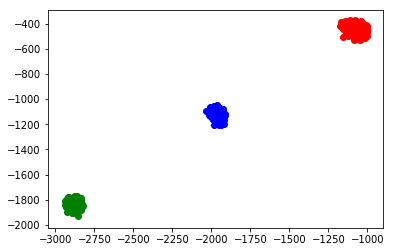

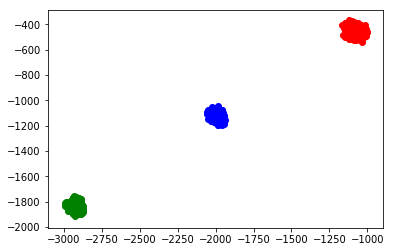

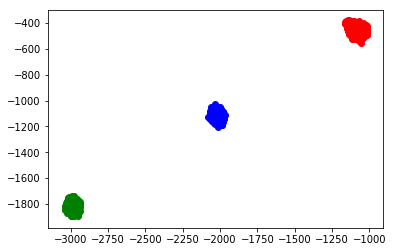

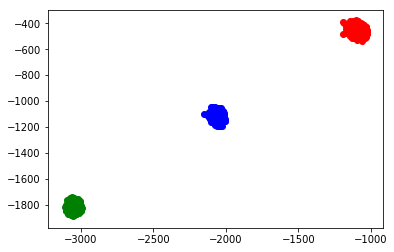

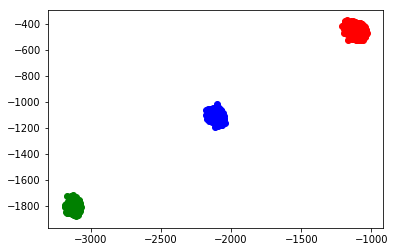

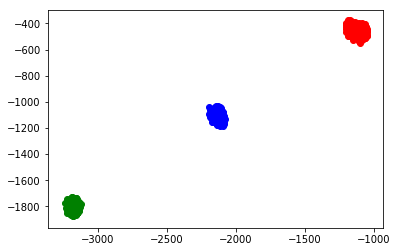

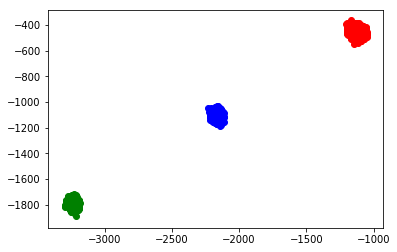

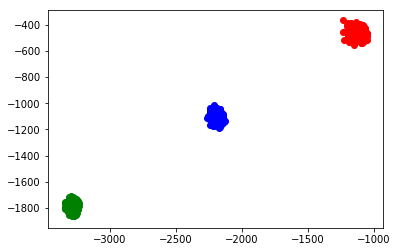

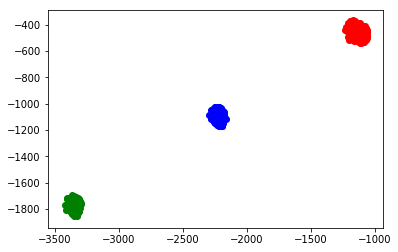

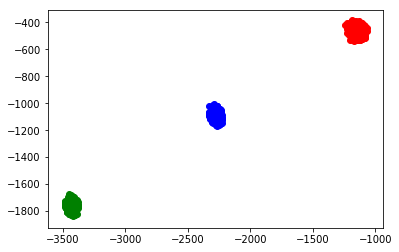

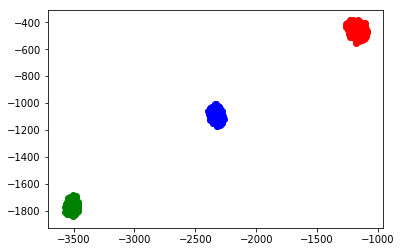

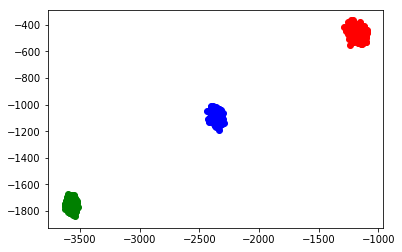

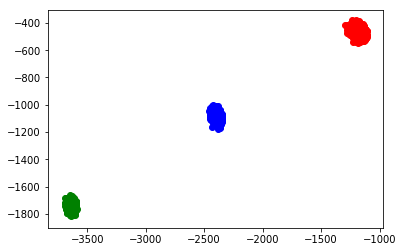

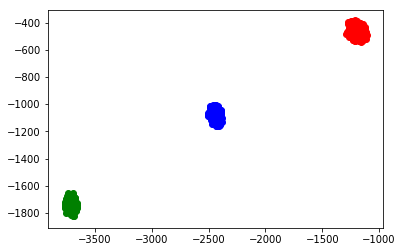

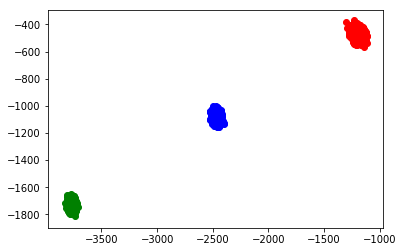

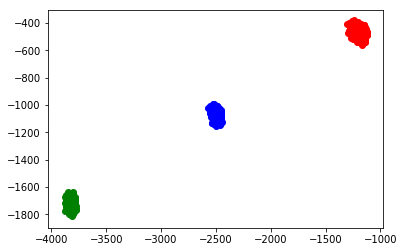

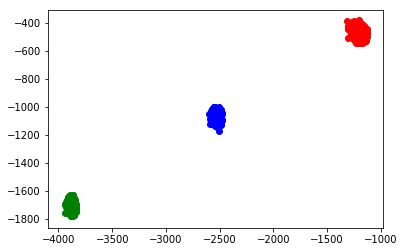

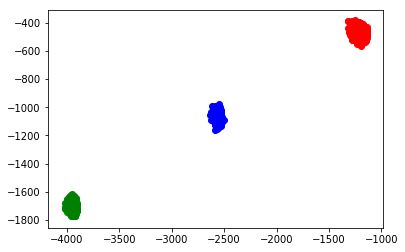

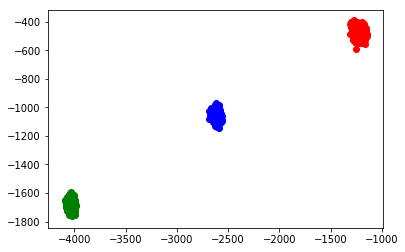

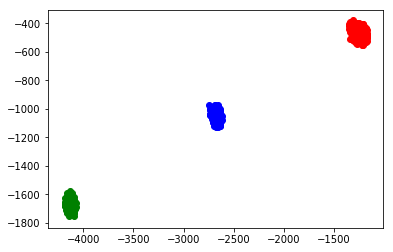

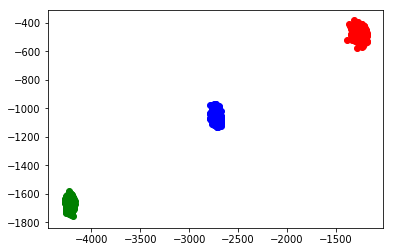

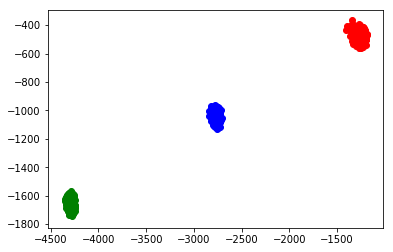

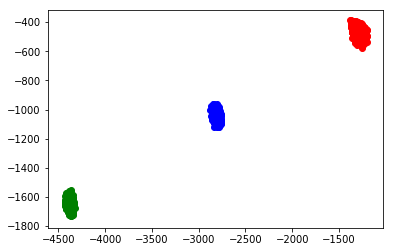

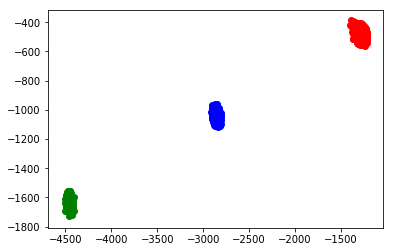

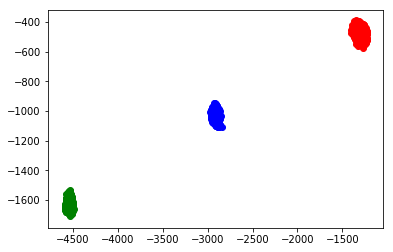

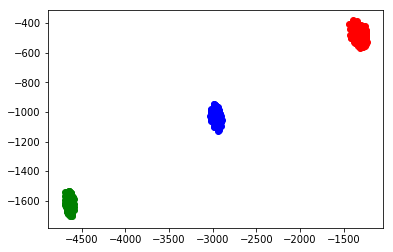

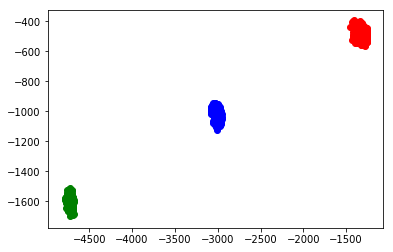

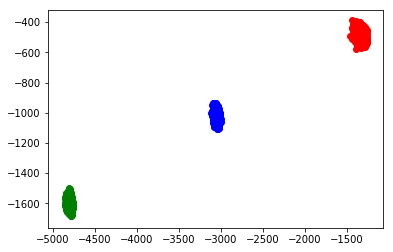

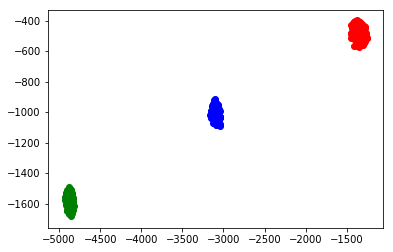

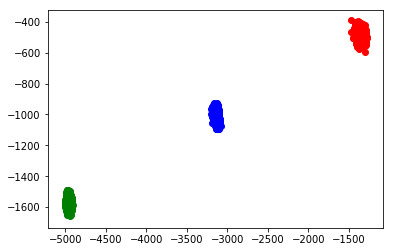

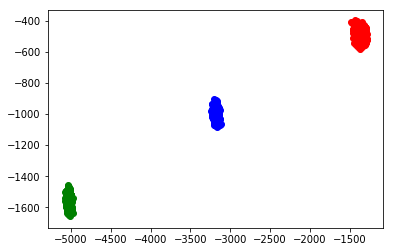

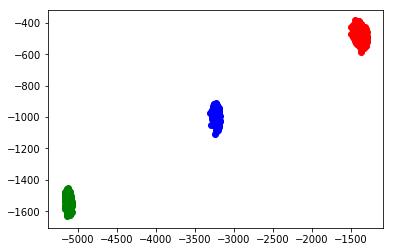

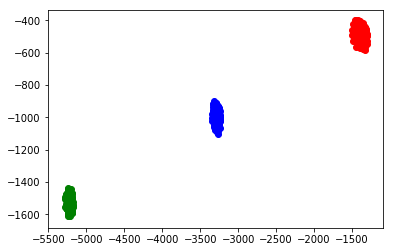

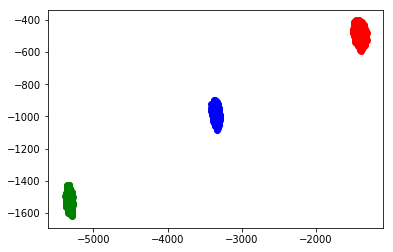

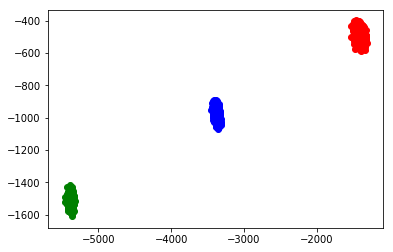

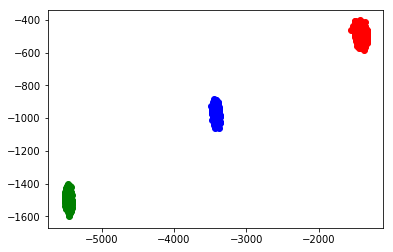

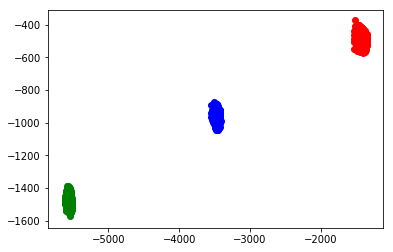

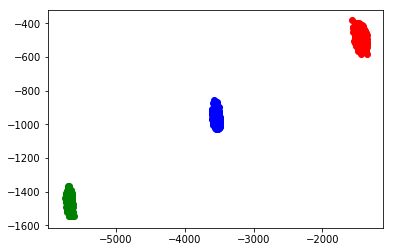

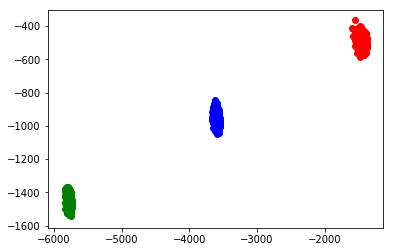

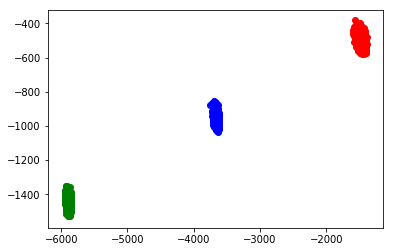

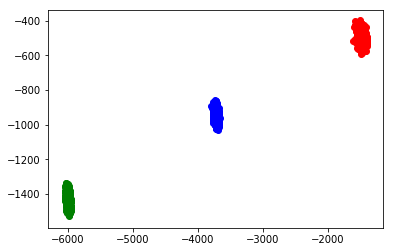

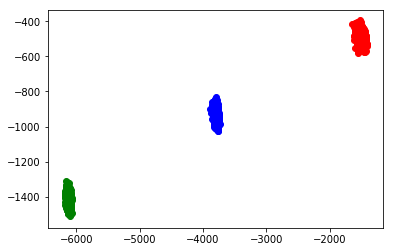

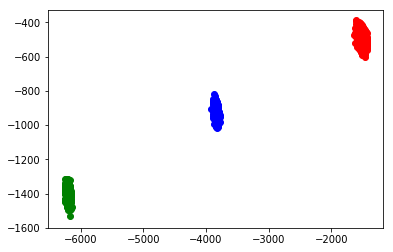

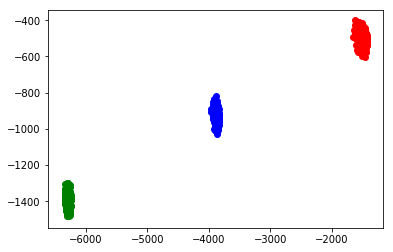

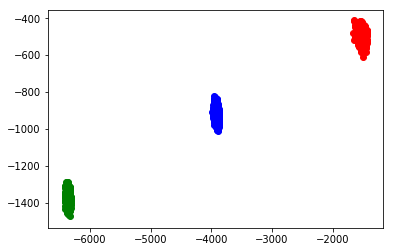

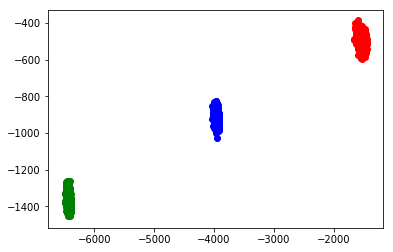

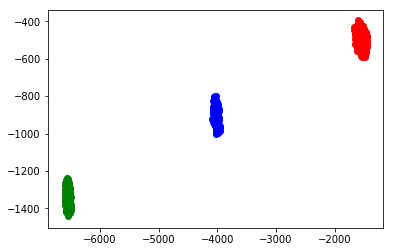

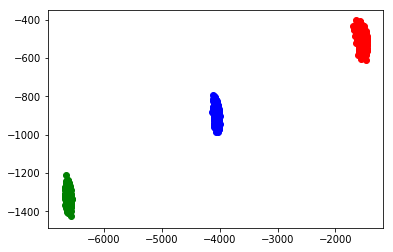

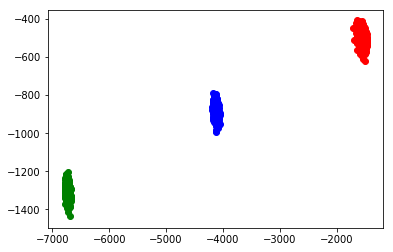

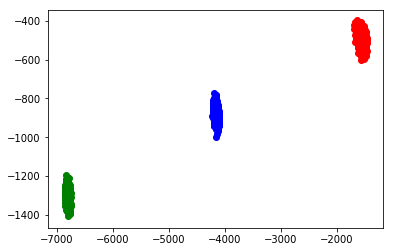

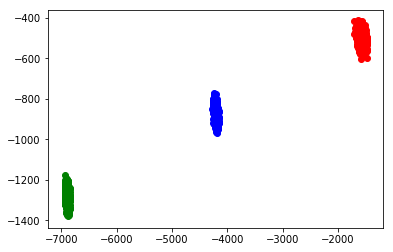

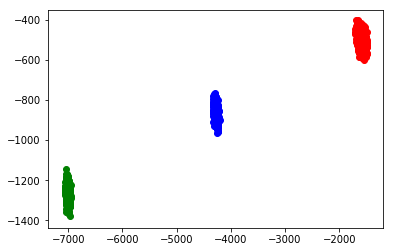

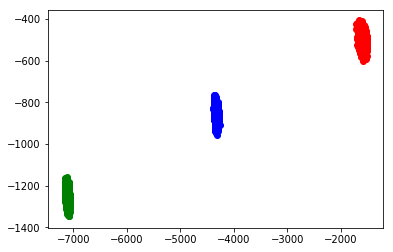

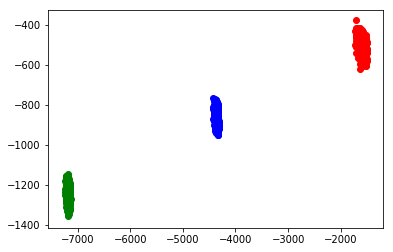

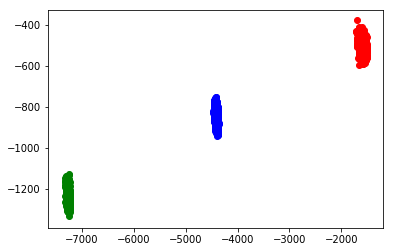

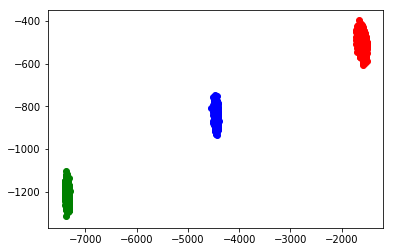

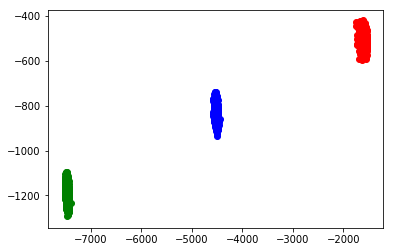

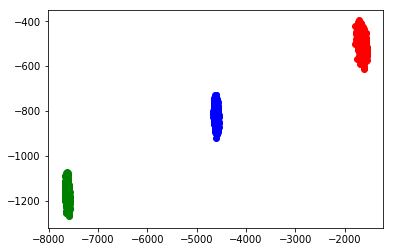

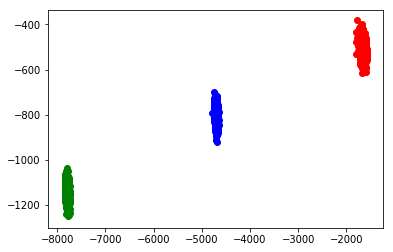

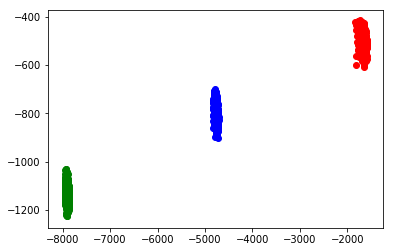

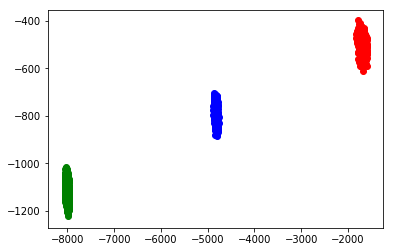

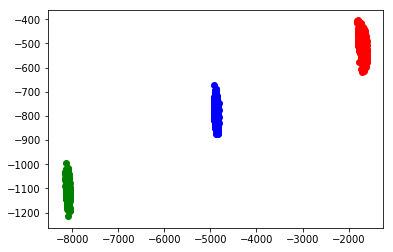

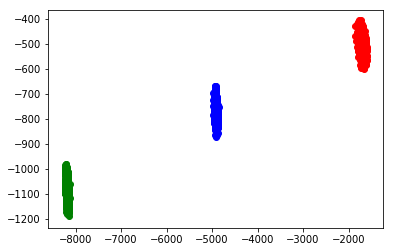

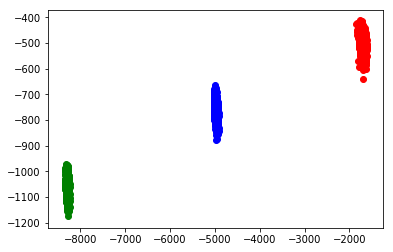

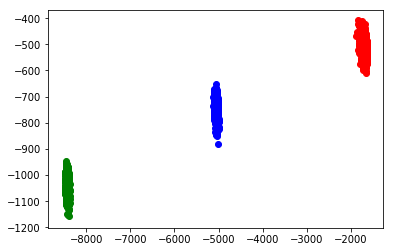

In [0]:
def train_gan():
  # Train Classifier
  
  # Initialize the variables (i.e. assign their default value)
  init = tf.global_variables_initializer()

  # Start training
  with tf.Session() as sess:

      # Run the initializer
      sess.run(init)

      sess.run(iter.initializer, feed_dict = {features: x_train, labels: y_train, batch_size: gan_batch_size, sample_size: 40000})

      # Train the Classifier First
      for i in range(3000):
        batch = sess.run(next_batch)
        model_optimizer.run(feed_dict={ x: batch[0], y: batch[1]})
        if i % 500 == 0:
          train_accuracy = accuracy.eval(feed_dict={x: batch[0], y: batch[1] })
          print('Epoch %d, training accuracy %g' % (i, train_accuracy))    

      test_acc, y_prediction,y_prop = sess.run([accuracy, y_pred, y_ml], feed_dict={x: x_train, y: y_train})
      print("test acc:", test_acc)

      cluster1 = []
      cluster2 = []
      cluster3 = []
      for i in range(0, num_data*NUM_LABEL):
        if y_prediction[i] == 0:
          cluster1.append(x_train[i])
        elif y_prediction[i] == 1:
          cluster2.append(x_train[i])
        else:
          cluster3.append(x_train[i])

      cluster1 = np.array(cluster1)
      cluster2 = np.array(cluster2)
      cluster3 = np.array(cluster3)
      print('cluster1: ', cluster1.shape, 'cluster2: ', cluster2.shape, 'cluster3:', cluster3.shape)
      plt.scatter(cluster1[:,0], cluster1[:,1],c='r')
      plt.scatter(cluster2[:,0], cluster2[:,1],c='b')
      plt.scatter(cluster3[:,0], cluster3[:,1],c='g')
      plt.savefig('Classifier_plot')
      
      #Train GAN
      for i in range(1000000):
        batch_x = aux_data
        
        # Sample random noise 
        z = np.random.uniform(-1., 1., size=[gan_batch_size, noise_dim])
       
        desired = np.zeros([gan_batch_size, NUM_LABEL])
        for j in range(NUM_LABEL):
          desired[j*500:(j+1)*500, j] = 1.
          
        #! Train Discriminator
#         train_disc.run(feed_dict={desired_label: desired,  gen_input: z})
#         if i % 5 == 0:
        train_gen.run(feed_dict={desired_label: desired,  gen_input: z})
       
        if i % 2000 == 0:
          gl = sess.run(gan_class_loss, feed_dict={desired_label: desired,  gen_input: z})
          print('Epoch %i: Generator Loss: %f' % (i, gl))
          plot_gan_image('gan_out',str(i), sess)
      
      
if __name__ == '__main__':
  train_gan()